In [29]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [30]:
import os
dataset_path = 'data/'  
csv_file = os.path.join(dataset_path, 'alzheimers_prediction_dataset.csv')  
df = pd.read_csv(csv_file)
print(df.head())

        Country  Age  Gender  Education Level   BMI Physical Activity Level  \
0         Spain   90    Male                1  33.0                  Medium   
1     Argentina   72    Male                7  29.9                  Medium   
2  South Africa   86  Female               19  22.9                    High   
3         China   53    Male               17  31.2                     Low   
4        Sweden   58  Female                3  30.0                    High   

  Smoking Status Alcohol Consumption Diabetes Hypertension  ...  \
0          Never        Occasionally       No           No  ...   
1         Former               Never       No           No  ...   
2        Current        Occasionally       No          Yes  ...   
3          Never           Regularly      Yes           No  ...   
4         Former               Never      Yes           No  ...   

  Dietary Habits Air Pollution Exposure  Employment Status Marital Status  \
0        Healthy                   High      

In [31]:
default_models_params = {
    'lr': {
        'model_cls': LogisticRegression,
        'init_params': {'class_weight': 'balanced', 'random_state': 42, 'max_iter': 1000},
        'param_grid': {'C': [0.01, 0.1, 1, 10]}
    },
    'rf': {
        'model_cls': RandomForestClassifier,
        'init_params': {'class_weight': 'balanced', 'random_state': 42},
        'param_grid': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
    },
    #'svm': {
    #    'model_cls': SVC,
    #    'init_params': {'probability': True, 'class_weight': 'balanced', 'random_state': 42},
    #    'param_grid': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    #},
    'gb': {
        'model_cls': GradientBoostingClassifier,
        'init_params': {'random_state': 42},
        'param_grid': {'n_estimators': [50, 100], 'max_depth': [3, 5]}
    },
    'knn': {
        'model_cls': KNeighborsClassifier,
        'init_params': {},
        'param_grid': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    },
    'xgb': {
        'model_cls': XGBClassifier,
        'init_params': {'random_state': 42, 'eval_metric': 'auc'},
        'param_grid': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
    },
    'mlp': {
        'model_cls': MLPClassifier,
        'init_params': {'random_state': 42, 'max_iter': 1000},
        'param_grid': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001]}
    }
}

os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
def train_and_save_models(df, models_params=None, validation=True, verbose=True, 
    save_paths={'model': 'alzheimers_model',
                'preprocessor': 'preprocessor',
                'feature_info': 'feature_info'
    }):
    """Train models from scratch and save them. Handle multiple models, validation split, and performance logging."""
        
    if models_params is None:
        models_params = default_models_params
    
    X = df.drop('Alzheimer’s Diagnosis', axis=1)
    y = df['Alzheimer’s Diagnosis'].map({'No': 0, 'Yes': 1})
    
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = X.select_dtypes(include=['object']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat_cols)
        ])
    
    X_processed = preprocessor.fit_transform(X)
    
    if validation:
        # Split into train (60%), val (20%), test (20%)
        X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
        if verbose:
            print("Data split: Train/Val/Test")
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)
        X_val, y_val = None, None
        if verbose:
            print("Data split: Train/Test (no validation)")
    
    trained_models = {}
    
    for model_name, model_info in models_params.items():
        if verbose:
            print(f"\nTraining {model_name}...")
        
        model_cls = model_info['model_cls']
        init_params = model_info.get('init_params', {}).copy()
        
        if model_name == 'xgb':
            scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() if (y_train == 1).sum() > 0 else 1
            init_params['scale_pos_weight'] = scale_pos_weight
            if verbose:
                print(f"Set scale_pos_weight to {scale_pos_weight} for XGBoost")
        
        model = model_cls(**init_params)
        grid = GridSearchCV(model, model_info['param_grid'], cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        trained_models[model_name] = grid
        
        model_path = os.path.join('models', f'{save_paths["model"]}_{model_name}.pkl')
        joblib.dump(grid.best_estimator_, model_path)

        #grid_path = os.path.join('models', f'alzheimers_{model_name}_gridsearch.pkl')
        #joblib.dump(grid, grid_path)
        
        if verbose:
            print(f"Best params for {model_name}: {grid.best_params_}")
        
        train_metrics = evaluate_model(X_train, y_train, model_type=model_name, processed_data=True, filepath=os.path.join('results', 'train_model_performances.csv'), save_paths=save_paths)
        if verbose:
            print(f"{model_name} Train ROC-AUC: {train_metrics.get('roc_auc', 'N/A')}")
        
        if validation and X_val is not None:
            val_metrics = evaluate_model(X_val, y_val, model_type=model_name, processed_data=True, filepath=os.path.join('results', 'val_model_performances.csv'), save_paths=save_paths)
            if verbose:
                print(f"{model_name} Val ROC-AUC: {val_metrics.get('roc_auc', 'N/A')}")
    
    preprocessor_path = os.path.join('models', f'{save_paths["preprocessor"]}.pkl')
    joblib.dump(preprocessor, preprocessor_path)

    feature_info_path = os.path.join('models', f'{save_paths["feature_info"]}.pkl')
    joblib.dump({
        'num_cols': list(num_cols),
        'cat_cols': list(cat_cols),
        'all_features': list(X.columns)
    }, feature_info_path)
    
    if verbose:
        print("\nModels, preprocessor, and feature info saved successfully!")
        print(f"Models saved in: {os.path.relpath('models')}")
        print(f"Results saved in: {os.path.relpath('results')}")
    
    return trained_models, preprocessor, X_train, X_val, X_test, y_train, y_val, y_test

def load_models_and_preprocessor(model_types=None, 
                                file_paths={'model': 'alzheimers_model',
                                            'preprocessor': 'preprocessor',
                                            'feature_info': 'feature_info'}
    ):
    """Load previously saved models and preprocessor."""
    if model_types is None:
        model_types = list(default_models_params.keys()) 
    
    if isinstance(model_types, str):
        model_types = [model_types]
    
    models = {}
    for mt in model_types:
        try:
            model_path = os.path.join('models', f'{file_paths["model"]}_{mt}.pkl')
            models[mt] = joblib.load(model_path)
            print(f"Loaded {mt} model from: {os.path.relpath(model_path)}")
        except FileNotFoundError:
            print(f"Warning: {mt} model file not found in models folder.")
            alt_path = f'alzheimers_{mt}_model.pkl'
            if os.path.exists(alt_path):
                models[mt] = joblib.load(alt_path)
                print(f"Loaded {mt} model from alternative location: {alt_path}")
    
    try:
        preprocessor_path = os.path.join('models', f'{file_paths["preprocessor"]}.pkl')
        preprocessor = joblib.load(preprocessor_path)
        
        feature_info_path = os.path.join('models', f'{file_paths["feature_info"]}.pkl')
        feature_info = joblib.load(feature_info_path)
        
        print(f"Loaded preprocessor and feature info from models folder")
    except FileNotFoundError as e:
        print(f"Error loading preprocessor or feature info: {e}")
        try:
            preprocessor = joblib.load('preprocessor.pkl')
            feature_info = joblib.load('feature_info.pkl')
            print("Loaded from alternative locations")
        except:
            preprocessor = None
            feature_info = None
    
    return models, preprocessor, feature_info

def evaluate_model(new_X, new_y, model_type='rf', processed_data=False, filepath=None, save_paths=None):
    """
    Evaluate model performance on new data.
    """
    if filepath is None:
        filepath = os.path.join('results', 'model_performances.csv')
    elif not os.path.dirname(filepath):  
        filepath = os.path.join('results', filepath)

    if isinstance(model_type, list):
        models, preprocessor, _ = load_models_and_preprocessor(model_type, file_paths=save_paths)
        metrics_dict = {}
        for mt in model_type:
            if mt not in models:
                continue
            model = models[mt]
            metrics_dict[mt] = _compute_metrics(new_X, new_y, model, preprocessor, processed_data)
        
        if metrics_dict:
            metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
            metrics_df.to_csv(filepath, index_label='model')
            print(f"Performances saved to {filepath}")
            
            best_model = metrics_df['roc_auc'].idxmax()
            best_score = metrics_df['roc_auc'].max()
            print(f"Best model: {best_model} with ROC-AUC {best_score}")
            return metrics_dict, best_model
        else:
            return {}, None
    
    else:
        models, preprocessor, _ = load_models_and_preprocessor([model_type], file_paths=save_paths)
        model = models.get(model_type)
        if model is None:
            print(f"Error: Model {model_type} not loaded.")
            return {}

        metrics = _compute_metrics(new_X, new_y, model, preprocessor, processed_data)

        if filepath:
            timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
            individual_path = os.path.join('results', f'{model_type}_performance_{timestamp}.csv')
            pd.DataFrame([metrics]).to_csv(individual_path, index=False)
        
        return metrics

def _compute_metrics(new_X, new_y, model, preprocessor, processed_data):
    """Helper to compute metrics"""

    if not processed_data:
        new_X = preprocessor.transform(new_X)
    
    y_pred = model.predict(new_X)
    metrics = {
        'accuracy': accuracy_score(new_y, y_pred),
        'precision': precision_score(new_y, y_pred, zero_division=0),
        'recall': recall_score(new_y, y_pred, zero_division=0),
        'f1_score': f1_score(new_y, y_pred, zero_division=0)
    }

    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(new_X)[:, 1]
        metrics['roc_auc'] = roc_auc_score(new_y, y_pred_proba)

    cm = confusion_matrix(new_y, y_pred)
    metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp'] = cm.ravel()

    return metrics

In [32]:
save_paths={'model': 'alzheimers_model',
            'preprocessor': 'preprocessor',
            'feature_info': 'feature_info'
    }
trained_models, preprocessor, X_train, X_val, X_test, y_train, y_val, y_test = train_and_save_models(df, 
                                                                                                    models_params=default_models_params, 
                                                                                                    save_paths=save_paths)

Data split: Train/Val/Test

Training lr...
Best params for lr: {'C': 0.1}
Loaded lr model from: models/alzheimers_model_lr.pkl
Error loading preprocessor or feature info: [Errno 2] No such file or directory: 'models/preprocessor.pkl'
lr Train ROC-AUC: 0.7917843261176399
Loaded lr model from: models/alzheimers_model_lr.pkl
Error loading preprocessor or feature info: [Errno 2] No such file or directory: 'models/preprocessor.pkl'
lr Val ROC-AUC: 0.7859223021842926

Training rf...
Best params for rf: {'max_depth': 10, 'n_estimators': 200}
Loaded rf model from: models/alzheimers_model_rf.pkl
Error loading preprocessor or feature info: [Errno 2] No such file or directory: 'models/preprocessor.pkl'
rf Train ROC-AUC: 0.8519246963570855
Loaded rf model from: models/alzheimers_model_rf.pkl
Error loading preprocessor or feature info: [Errno 2] No such file or directory: 'models/preprocessor.pkl'
rf Val ROC-AUC: 0.7950601140270571

Training gb...
Best params for gb: {'max_depth': 3, 'n_estimators'

In [33]:
metrics, best = evaluate_model(X_test, y_test, model_type=['lr', 'rf', 'gb', 'knn', 'xgb', 'mlp'], processed_data=True, filepath='test_model_performances.csv', save_paths=save_paths)

Loaded lr model from: models/alzheimers_model_lr.pkl
Loaded rf model from: models/alzheimers_model_rf.pkl
Loaded gb model from: models/alzheimers_model_gb.pkl
Loaded knn model from: models/alzheimers_model_knn.pkl
Loaded xgb model from: models/alzheimers_model_xgb.pkl
Loaded mlp model from: models/alzheimers_model_mlp.pkl
Loaded preprocessor and feature info from models folder
Performances saved to results/test_model_performances.csv
Best model: xgb with ROC-AUC 0.808035747811577


In [34]:
def predict_alzheimers(new_data_dict, model_type='rf', 
                       model=None, preprocessor=None, 
                       feature_info=None, threshold=0.5, 
                       save_paths={'model': 'alzheimers_model',
                                    'preprocessor': 'preprocessor',
                                    'feature_info': 'feature_info'}
    ):
    """
    Predict Alzheimer's diagnosis for new sample
    
    Parameters:
    -----------
    new_data_dict : dict
        Dictionary containing feature values
    model_type : str
        Model type key, e.g., 'rf', 'xgb', etc.
    model : trained model or dict of models
        If None, loads from saved file
    preprocessor : fitted preprocessor
        If None, loads from saved file
    feature_info : dict
        Feature metadata, loaded if None
    threshold : float
        Decision threshold
    
    Returns:
    --------
    dict: Prediction results
    """
    
    if model is None or preprocessor is None or feature_info is None:
        models, preprocessor, feature_info = load_models_and_preprocessor(model_types=model_type, file_paths=save_paths)
        if not models or model_type not in models:
            return {"error": f"Model {model_type} not loaded"}
        model = models[model_type]
    elif isinstance(model, dict):
        if model_type in model:
            model = model[model_type]
        else:
            return {"error": f"Model {model_type} not found in provided dict"}
    
    new_df = pd.DataFrame([new_data_dict])
    
    expected_features = feature_info['all_features']
    missing_features = set(expected_features) - set(new_df.columns)
    extra_features = set(new_df.columns) - set(expected_features)
    
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        for feat in missing_features:
            new_df[feat] = np.nan
    
    if extra_features:
        print(f"Warning: Extra features provided: {extra_features}")
        new_df = new_df[expected_features]
    
    try:
        new_processed = preprocessor.transform(new_df)
    except Exception as e:
        return {"error": f"Preprocessing failed: {str(e)}"}
    
    try:
        prob = model.predict_proba(new_processed)[0][1]
        prediction = 1 if prob >= threshold else 0
        confidence = prob if prediction == 1 else 1 - prob
        
        feature_importance = None
        if hasattr(model, 'feature_importances_'):
            importance_dict = dict(zip(
                preprocessor.get_feature_names_out(),
                model.feature_importances_
            ))

            top_features = sorted(importance_dict.items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)[:10]
            feature_importance = dict(top_features)
        
        result = {
            'diagnosis': 'Yes' if prediction == 1 else 'No',
            'probability': float(prob),
            'confidence': float(confidence),
            'threshold_used': float(threshold),
            'model_used': model_type.upper(),
            'feature_importance': feature_importance,
            'risk_level': categorize_risk(prob)
        }
        
        return result
        
    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

def categorize_risk(probability):
    """Categorize risk based on probability"""
    if probability < 0.3:
        return "Low Risk"
    elif probability < 0.6:
        return "Moderate Risk"
    elif probability < 0.8:
        return "High Risk"
    else:
        return "Very High Risk"

In [35]:
def predict_batch(new_data_df, model_type='rf', threshold=0.5,
                save_paths={'model': 'alzheimers_model',
                            'preprocessor': 'preprocessor',
                            'feature_info': 'feature_info'}
):
    """
    Predict for multiple samples at once
    
    Parameters:
    -----------
    new_data_df : pandas DataFrame
        DataFrame containing multiple samples
    model_type : str
        Model type key, e.g., 'rf', 'xgb', etc.
    threshold : float
        Decision threshold
    
    Returns:
    --------
    DataFrame with predictions
    """
    
    models, preprocessor, feature_info = load_models_and_preprocessor(model_types=model_type, file_paths=save_paths)
    if not models or model_type not in models:
        print(f"Error: Model {model_type} not loaded.")
        return pd.DataFrame()
    
    model = models[model_type]
    
    expected_features = feature_info['all_features']
    missing_features = set(expected_features) - set(new_data_df.columns)
    
    if missing_features:
        print(f"Warning: Adding missing features: {missing_features}")
        for feat in missing_features:
            new_data_df[feat] = np.nan
    
    new_data_df = new_data_df[expected_features]
    
    try:
        new_processed = preprocessor.transform(new_data_df)
        probabilities = model.predict_proba(new_processed)[:, 1]
        predictions = (probabilities >= threshold).astype(int)
        
        results_df = new_data_df.copy()
        results_df['Predicted_Diagnosis'] = ['Yes' if p == 1 else 'No' for p in predictions]
        results_df['Probability'] = probabilities
        results_df['Risk_Level'] = [categorize_risk(p) for p in probabilities]
        results_df['Confidence'] = np.where(
            predictions == 1, 
            probabilities, 
            1 - probabilities
        )
        
        return results_df
        
    except Exception as e:
        print(f"Batch prediction failed: {e}")
        return pd.DataFrame()

In [36]:
sample_patient = {
    'Country': 'Spain',
    'Age': 90,
    'Gender': 'Male',
    'Education Level': 1,
    'BMI': 33.0,
    'Physical Activity Level': 'Medium',
    'Smoking Status': 'Never',
    'Alcohol Consumption': 'Occasionally',
    'Diabetes': 'No',
    'Hypertension': 'No',
    'Cholesterol Level': 'Normal',
    'Family History of Alzheimer’s': 'No',
    'Cognitive Test Score': 90,
    'Depression Level': 'Low',
    'Sleep Quality': 'Poor',
    'Dietary Habits': 'Healthy',
    'Air Pollution Exposure': 'High',
    'Employment Status': 'Retured',
    'Marital Status': 'Single',
    'Genetic Risk Factor (APOE-ε4 allele)': 'No',
    'Social Engagement Level': 'Low',
    'Income Level': 'Medium',
    'Stress Levels': 'High',
    'Urban vs Rural Living': 'Urban'
}

# Alzheimer’s Diagnosis ==> No
sample_patient2 = {
        'Country': 'USA',
        'Age': 30,
        'Gender': 'Male',
        'Education Level': 12,
        'BMI': 26.5,
        'Physical Activity Level': 'Medium',
        'Smoking Status': 'Former',
        'Alcohol Consumption': 'Moderate',
        'Diabetes': 'No',
        'Hypertension': 'Yes',
        'Cholesterol Level': 'High',
        'Family History of Alzheimer’s': 'Yes',
        'Genetic Risk Factor (APOE-ε4 allele)': 'Yes',
        'Cognitive Test Score': 22,
        'Depression Level': 'Low',
        'Sleep Quality': 'Poor',
        'Dietary Habits': 'Average',
        'Employment Status': 'Retired',
        'Marital Status': 'Married',
        'Social Engagement Level': 'Medium',
        'Income Level': 'Middle',
        'Stress Levels': 'Medium',
        'Urban vs Rural Living': 'Urban',
        'Air Pollution Exposure': 'Medium'
    }
    
model, preprocessor, feature_info = load_models_and_preprocessor(model_types='rf', file_paths=save_paths)

result = predict_alzheimers(
        sample_patient,
        model_type='rf',
        model=model, 
        preprocessor=preprocessor, 
        feature_info=feature_info,
        threshold=0.6
    )
    
print(f"Prediction Result: {result}")
    

Loaded rf model from: models/alzheimers_model_rf.pkl
Loaded preprocessor and feature info from models folder
Prediction Result: {'diagnosis': 'No', 'probability': 0.5783215743096121, 'confidence': 0.42167842569038794, 'threshold_used': 0.6, 'model_used': 'RF', 'feature_importance': {'num__Age': np.float64(0.532863160495897), 'cat__Genetic Risk Factor (APOE-ε4 allele)_Yes': np.float64(0.07499109500973443), 'cat__Genetic Risk Factor (APOE-ε4 allele)_No': np.float64(0.06706637613135394), 'cat__Family History of Alzheimer’s_Yes': np.float64(0.036600016802217306), 'cat__Family History of Alzheimer’s_No': np.float64(0.034773984724978585), 'num__BMI': np.float64(0.024464707897405007), 'num__Cognitive Test Score': np.float64(0.021825002180314853), 'num__Education Level': np.float64(0.017660896145939874), 'cat__Country_Russia': np.float64(0.005330747689847775), 'cat__Country_India': np.float64(0.004808221185982292)}, 'risk_level': 'Moderate Risk'}


## Would the model performance improve if top 10 feature importance were used to train the models?

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')


plt.rcParams.update({
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

In [38]:
print("Loading trained models and preprocessor...")
models, preprocessor, feature_info = load_models_and_preprocessor(['rf'], file_paths=save_paths)
rf_model = models['rf']

Loading trained models and preprocessor...
Loaded rf model from: models/alzheimers_model_rf.pkl
Loaded preprocessor and feature info from models folder


In [39]:
def get_feature_names(preprocessor):
    """Get feature names after preprocessing"""
    feature_names = []
    
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(list(columns))
        elif name == 'cat':
            # Get categories from OneHotEncoder
            encoder = transformer.named_steps['encoder']
            if hasattr(encoder, 'get_feature_names_out'):
                encoded_features = encoder.get_feature_names_out(columns)
                feature_names.extend(encoded_features)
            else:
                # Fallback: create simple names
                for col in columns:
                    # Use original data to get unique values
                    if 'df' in globals():
                        unique_vals = df[col].dropna().unique()
                        for val in unique_vals:
                            feature_names.append(f"{col}_{val}")
                    else:
                        # If df not available, create generic names
                        for i in range(len(columns)):
                            feature_names.append(f"{col}_cat{i}")
    
    return feature_names


Top 10 most important features:
Age: 0.5329
Genetic Risk Factor (APOE-ε4 allele)_Yes: 0.0750
Genetic Risk Factor (APOE-ε4 allele)_No: 0.0671
Family History of Alzheimer’s_Yes: 0.0366
Family History of Alzheimer’s_No: 0.0348
BMI: 0.0245
Cognitive Test Score: 0.0218
Education Level: 0.0177
Country_Russia: 0.0053
Country_India: 0.0048

Top 10 most important ORIGINAL columns (aggregated from one-hot):
Age: 0.5329
Genetic Risk Factor (APOE-ε4 allele): 0.1421
Family History of Alzheimer’s: 0.0714
Country: 0.0402
BMI: 0.0245
Cognitive Test Score: 0.0218
Education Level: 0.0177
Alcohol Consumption: 0.0103
Stress Levels: 0.0101
Depression Level: 0.0100


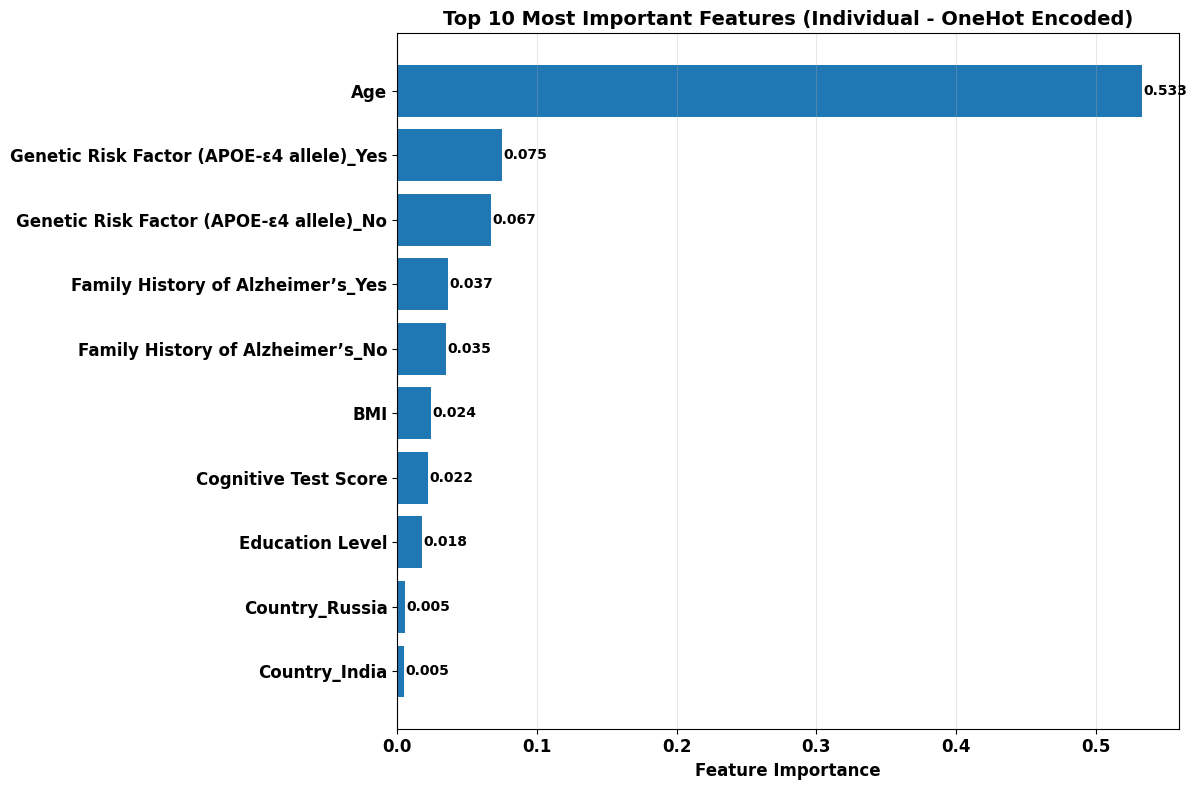

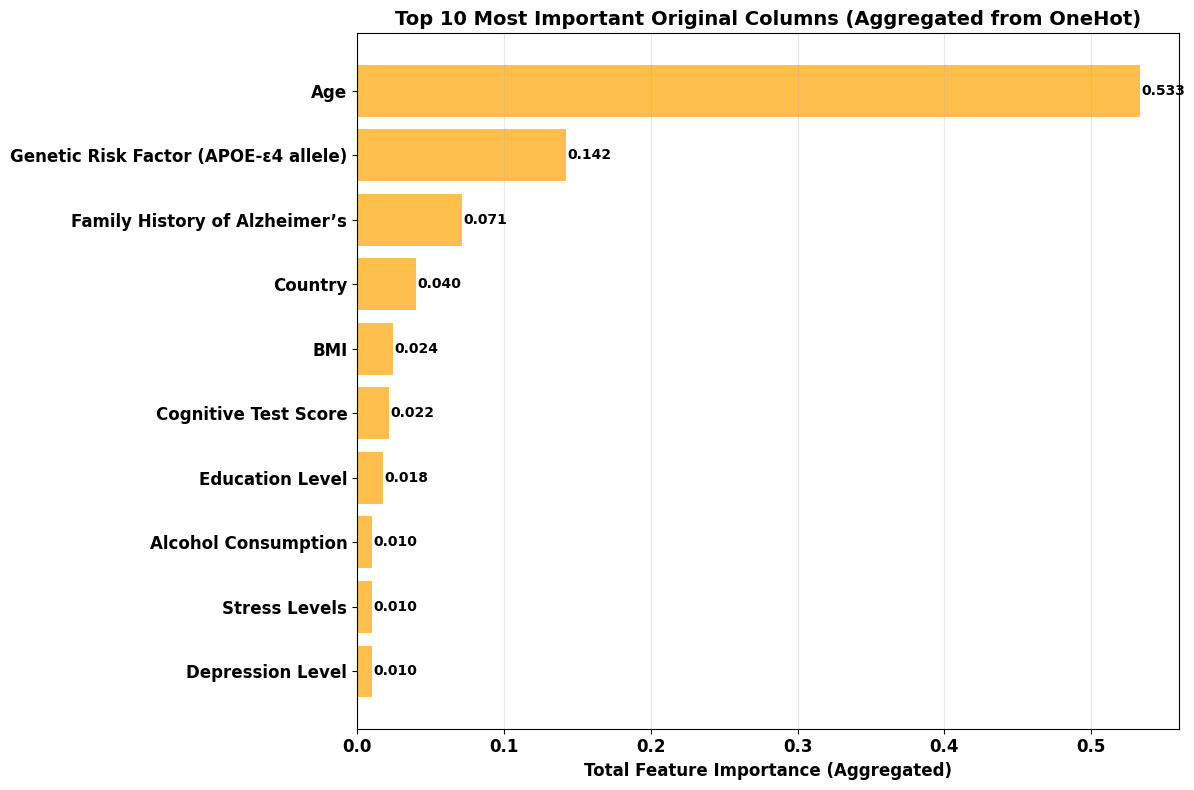

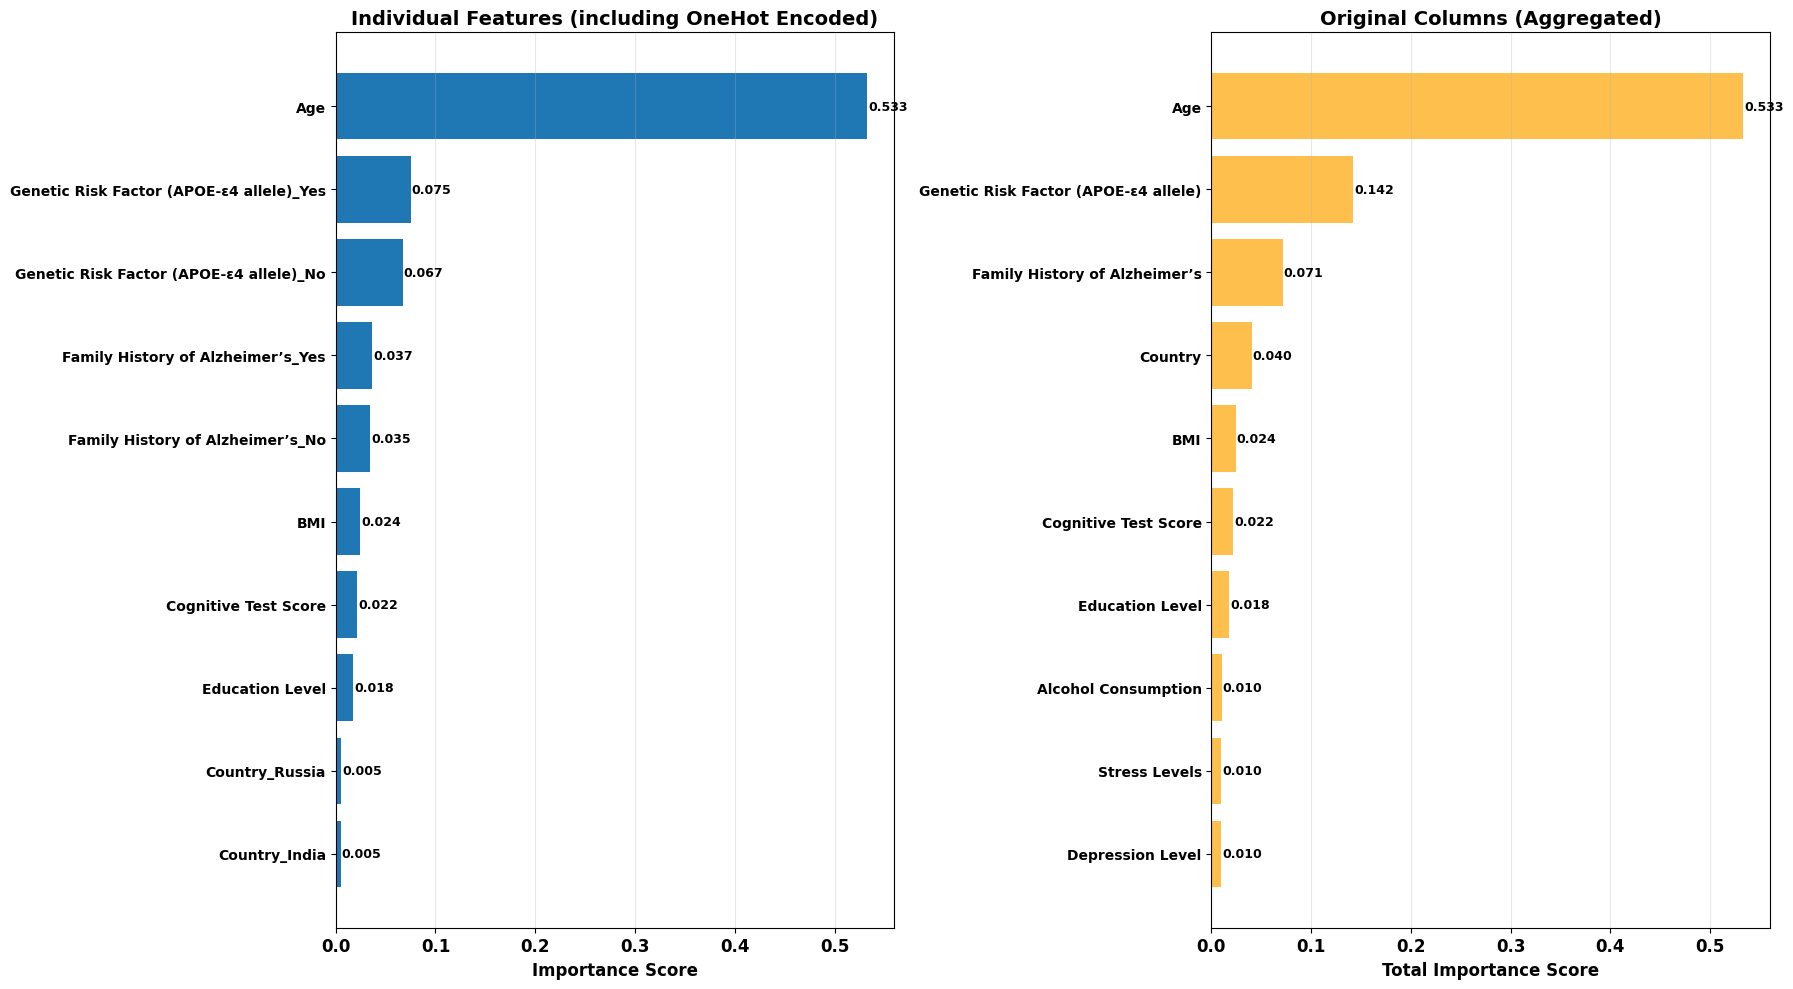


Genetic Risk Factor (APOE-ε4 allele):
  - Yes: 0.0750
  - No: 0.0671

Family History of Alzheimer’s:
  - Yes: 0.0366
  - No: 0.0348

Country:
  - Russia: 0.0053
  - India: 0.0048
  - Brazil: 0.0047
  - Japan: 0.0033
  - Mexico: 0.0032
  - South Africa: 0.0029
  - Sweden: 0.0028
  - Canada: 0.0024
  - Norway: 0.0021
  - Australia: 0.0010
  - USA: 0.0010
  - France: 0.0008
  - China: 0.0008
  - Argentina: 0.0008
  - Italy: 0.0008
  - UK: 0.0008
  - Germany: 0.0007
  - Spain: 0.0007
  - Saudi Arabia: 0.0007
  - South Korea: 0.0006

Original columns represented in top 10: ['Age', 'Genetic Risk Factor (APOE-ε4 allele)', 'Family History of Alzheimer’s', 'Country', 'BMI', 'Cognitive Test Score', 'Education Level', 'Alcohol Consumption', 'Stress Levels', 'Depression Level']

TRAINING MODELS WITH TOP 10 ORIGINAL COLUMNS
Training all models with top 10 original columns...
Loaded lr model from: models/alzheimers_model_top10_lr.pkl
Error loading preprocessor or feature info: [Errno 2] No such fil

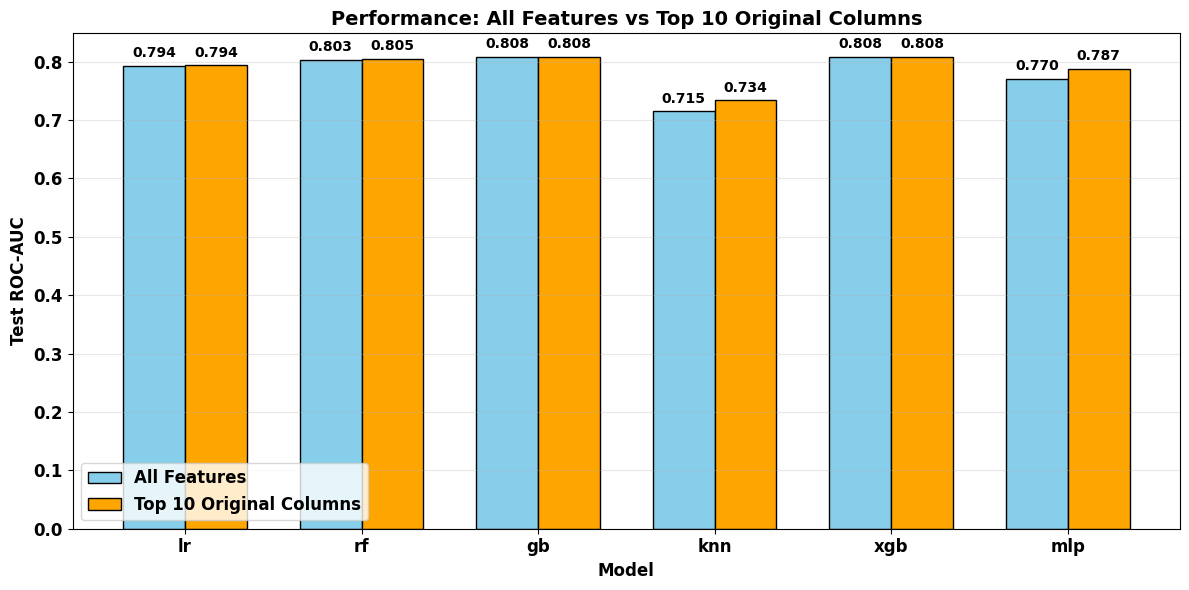


Detailed comparison of all metrics:
     Original_accuracy  Top10_accuracy  accuracy_diff  Original_precision  \
lr              0.7175          0.7179         0.0004              0.6395   
rf              0.7265          0.7269         0.0004              0.6413   
gb              0.7315          0.7287        -0.0028              0.6679   
knn             0.6721          0.6826         0.0104              0.6252   
xgb             0.7288          0.7260        -0.0028              0.6467   
mlp             0.7026          0.7114         0.0089              0.6484   

     Top10_precision  precision_diff  Original_recall  Top10_recall  \
lr            0.6400          0.0006           0.7262        0.7262   
rf            0.6421          0.0009           0.7682        0.7667   
gb            0.6587         -0.0092           0.6974        0.7138   
knn           0.6268          0.0016           0.5168        0.5740   
xgb           0.6391         -0.0076           0.7586        0.7749 

In [40]:
save_paths_top10={'model': 'alzheimers_model_top10',
            'preprocessor': 'preprocessor_top10',
            'feature_info': 'feature_info_top10'
    }

feature_names = get_feature_names(preprocessor)
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'feature': feature_names[:len(importances)], 
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    importance_df.to_csv('results/rf_feature_importance_full.csv', index=False)
    
    # Get top 10 features
    top_10_features = importance_df.head(10)
    print(f"\nTop 10 most important features:")
    for idx, row in top_10_features.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
    
    # create a dictionary to aggregate importance by original column
    original_col_importance = {}
    
    for feature, importance in zip(importance_df['feature'], importance_df['importance']):
        # Check if it's a one-hot encoded feature
        is_onehot = False
        original_col = feature
        
        for cat_col in feature_info['cat_cols']:
            if feature.startswith(cat_col + '_'):
                original_col = cat_col
                is_onehot = True
                break

        # aggregate importance for original columns
        if original_col not in original_col_importance:
            original_col_importance[original_col] = importance
        else:
            original_col_importance[original_col] += importance
    
    # create dataframe for original column importance
    original_importance_df = pd.DataFrame({
        'original_column': list(original_col_importance.keys()),
        'total_importance': list(original_col_importance.values())
    }).sort_values('total_importance', ascending=False)
    
    # Save original column importance
    original_importance_df.to_csv('results/rf_original_column_importance.csv', index=False)
    
    # Get top 10 original columns
    top_10_original = original_importance_df.head(10)
    
    print("\nTop 10 most important ORIGINAL columns (aggregated from one-hot):")
    for idx, row in top_10_original.iterrows():
        print(f"{row['original_column']}: {row['total_importance']:.4f}")
    
    # individual features (one-hot encoded)
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(top_10_features)), top_10_features['importance'].values[::-1])
    plt.yticks(range(len(top_10_features)), top_10_features['feature'].values[::-1])
    plt.xlabel('Feature Importance', fontweight='bold', fontsize=12)
    plt.title('Top 10 Most Important Features (Individual - OneHot Encoded)', 
              fontweight='bold', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('results/top_10_features_individual.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # original columns (aggregated) 
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(top_10_original)), top_10_original['total_importance'].values[::-1],
                   color='orange', alpha=0.7)
    plt.yticks(range(len(top_10_original)), top_10_original['original_column'].values[::-1])
    plt.xlabel('Total Feature Importance (Aggregated)', fontweight='bold', fontsize=12)
    plt.title('Top 10 Most Important Original Columns (Aggregated from OneHot)', 
              fontweight='bold', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('results/top_10_original_columns.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # plot: side-by-side comparison 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
    
    bars1 = ax1.barh(range(len(top_10_features)), top_10_features['importance'].values[::-1])
    ax1.set_yticks(range(len(top_10_features)))
    ax1.set_yticklabels(top_10_features['feature'].values[::-1], fontsize=10)
    ax1.set_xlabel('Importance Score', fontweight='bold', fontsize=12)
    ax1.set_title('Individual Features (including OneHot Encoded)', fontweight='bold', fontsize=14)
    ax1.grid(axis='x', alpha=0.3)
    
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)
    
    bars2 = ax2.barh(range(len(top_10_original)), top_10_original['total_importance'].values[::-1],
                     color='orange', alpha=0.7)
    ax2.set_yticks(range(len(top_10_original)))
    ax2.set_yticklabels(top_10_original['original_column'].values[::-1], fontsize=10)
    ax2.set_xlabel('Total Importance Score', fontweight='bold', fontsize=12)
    ax2.set_title('Original Columns (Aggregated)', fontweight='bold', fontsize=14)
    ax2.grid(axis='x', alpha=0.3)
    
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('results/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # plot: original column importance with breakdown
    # To show how each original column's importance is distributed across its one-hot categories
    for original_col in top_10_original['original_column'].head(5):
        # get all one-hot features for this column
        onehot_features = [f for f in importance_df['feature'] if f.startswith(original_col + '_')]
        
        if onehot_features:  # If it's a categorical column
            print(f"\n{original_col}:")
            onehot_importance = importance_df[importance_df['feature'].isin(onehot_features)]
            onehot_importance = onehot_importance.sort_values('importance', ascending=False)
            
            for _, row in onehot_importance.iterrows():
                feature_name = row['feature'].replace(f"{original_col}_", "")
                print(f"  - {feature_name}: {row['importance']:.4f}")
    
    # get original column names (before one-hot encoding)
    # We need to map back to original columns
    top_10_original_cols = list(top_10_original['original_column'].head(10))
    
    print(f"\nOriginal columns represented in top 10: {top_10_original_cols}")
    
    print("\nTRAINING MODELS WITH TOP 10 ORIGINAL COLUMNS")
    df_top = df[top_10_original_cols + ['Alzheimer’s Diagnosis']].copy()
    
    print("Training all models with top 10 original columns...")
    trained_models_top, preprocessor_top, X_train_top, X_val_top, X_test_top, y_train_top, y_val_top, y_test_top = train_and_save_models(
        df_top, 
        models_params=default_models_params,
        validation=True,
        verbose=False,
        save_paths=save_paths_top10  
    )
    
    # Evaluate all top feature models on test set
    print("\nEvaluating top 10 feature models on test set...")
    top_metrics, best_top_model = evaluate_model(
        X_test_top, 
        y_test_top, 
        model_type=['lr', 'rf', 'gb', 'knn', 'xgb', 'mlp'], 
        processed_data=True, 
        filepath='results/test_top10_model_performances.csv',
        save_paths=save_paths_top10 
    )
    
    print("\nPERFORMANCE COMPARISON: All Features vs Top 10 Original Columns")
    
    try:
        original_perf = pd.read_csv('results/test_model_performances.csv', index_col='model')
        top_perf = pd.read_csv('results/test_top10_model_performances.csv', index_col='model')
        
        comparison_df = pd.DataFrame()
        for model_name in default_models_params.keys():
            if model_name in original_perf.index and model_name in top_perf.index:
                comparison_df.loc[model_name, 'Original_Test_ROC_AUC'] = original_perf.loc[model_name, 'roc_auc']
                comparison_df.loc[model_name, 'Top10_Original_Test_ROC_AUC'] = top_perf.loc[model_name, 'roc_auc']
                comparison_df.loc[model_name, 'Difference'] = (
                    top_perf.loc[model_name, 'roc_auc'] - 
                    original_perf.loc[model_name, 'roc_auc']
                )
        
        print("Comparison of Test ROC-AUC scores:")
        print(comparison_df.round(4))
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        
        x = np.arange(len(comparison_df))
        width = 0.35
        
        plt.bar(x - width/2, comparison_df['Original_Test_ROC_AUC'], width, 
                label='All Features', color='skyblue', edgecolor='black')
        plt.bar(x + width/2, comparison_df['Top10_Original_Test_ROC_AUC'], width, 
                label='Top 10 Original Columns', color='orange', edgecolor='black')
        
        plt.xlabel('Model', fontweight='bold', fontsize=12)
        plt.ylabel('Test ROC-AUC', fontweight='bold', fontsize=12)
        plt.title('Performance: All Features vs Top 10 Original Columns', 
                 fontweight='bold', fontsize=14)
        plt.xticks(x, comparison_df.index)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        for i, (orig, top) in enumerate(zip(comparison_df['Original_Test_ROC_AUC'], 
                                           comparison_df['Top10_Original_Test_ROC_AUC'])):
            plt.text(i - width/2, orig + 0.01, f'{orig:.3f}', 
                    ha='center', va='bottom', fontweight='bold')
            plt.text(i + width/2, top + 0.01, f'{top:.3f}', 
                    ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('results/original_columns_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nDetailed comparison of all metrics:")
        detailed_comparison = pd.DataFrame()
        
        for model_name in default_models_params.keys():
            if model_name in original_perf.index and model_name in top_perf.index:
                for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
                    if metric in original_perf.columns and metric in top_perf.columns:
                        detailed_comparison.loc[model_name, f'Original_{metric}'] = original_perf.loc[model_name, metric]
                        detailed_comparison.loc[model_name, f'Top10_{metric}'] = top_perf.loc[model_name, metric]
                        detailed_comparison.loc[model_name, f'{metric}_diff'] = (
                            top_perf.loc[model_name, metric] - original_perf.loc[model_name, metric]
                        )
        
        print(detailed_comparison.round(4))
        
        print("\nSUMMARY STATISTICS")
        
        improved = (comparison_df['Difference'] > 0).sum()
        worsened = (comparison_df['Difference'] < 0).sum()
        same = (comparison_df['Difference'] == 0).sum()
        
        print(f"Models with improved ROC-AUC: {improved}/{len(comparison_df)}")
        print(f"Models with worsened ROC-AUC: {worsened}/{len(comparison_df)}")
        print(f"Models with unchanged ROC-AUC: {same}/{len(comparison_df)}")
        
        avg_improvement = comparison_df['Difference'].mean()
        if avg_improvement > 0:
            print(f"\nAverage ROC-AUC improvement: {avg_improvement:.4f}")
            print("Feature selection improved overall performance!")
        else:
            print(f"\nAverage ROC-AUC change: {avg_improvement:.4f}")
            print("Feature selection did not improve overall performance")
        
        # Find best overall model
        best_original_model = original_perf['roc_auc'].idxmax()
        best_original_score = original_perf['roc_auc'].max()
        best_top_model = top_perf['roc_auc'].idxmax()
        best_top_score = top_perf['roc_auc'].max()
        
        print(f"\nBest model with all features: {best_original_model} (ROC-AUC: {best_original_score:.4f})")
        print(f"Best model with top 10 features: {best_top_model} (ROC-AUC: {best_top_score:.4f})")
        
        # Calculate efficiency gain (reduction in features)
        total_features = len(feature_info['num_cols']) + len(feature_info['cat_cols'])
        print(f"\nFeature reduction: {total_features} → {len(top_10_original_cols)} features")
        print(f"Feature reduction: {(1 - len(top_10_original_cols)/total_features)*100:.1f}%")
        
        # Calculate performance per feature
        print(f"\nPerformance per feature (higher is better):")
        print(f"All features: {best_original_score/total_features:.6f}")
        print(f"Top 10 features: {best_top_score/len(top_10_original_cols):.6f}")
        
    except FileNotFoundError as e:
        print(f"Error loading performance files: {e}")
        print("Showing only top 10 features results...")
        if top_metrics:
            print("\nTop 10 feature models performance:")
            for model_name, metrics in top_metrics.items():
                print(f"{model_name}: ROC-AUC = {metrics.get('roc_auc', 'N/A'):.4f}")
    
    comparison_results = {
        'top_10_individual_features': list(top_10_features['feature']),
        'top_10_original_columns': top_10_original_cols,
        'original_column_importance': original_importance_df.to_dict('records'),
        'feature_reduction': {
            'original_features': total_features,
            'top_features': len(top_10_original_cols),
            'reduction_percentage': (1 - len(top_10_original_cols)/total_features)*100
        }
    }
    
    joblib.dump(comparison_results, 'results/original_feature_selection_results.pkl')
    
    if os.path.exists(f'models/{save_paths_top10["preprocessor"]}.pkl'):
        os.rename(f'models/{save_paths_top10["preprocessor"]}.pkl', 'models/preprocessor_top10_original.pkl')
    
else:
    print("RandomForest model doesn't have feature_importances_ attribute")

In [46]:
"""
Age: 0.5329
Genetic Risk Factor (APOE-ε4 allele): 0.1421
Family History of Alzheimer’s: 0.0714
Country: 0.0402
BMI: 0.0245
Cognitive Test Score: 0.0218
Education Level: 0.0177
Alcohol Consumption: 0.0103
Stress Levels: 0.0101
Depression Level: 0.0100
"""

sample_patient = {
    'Country': 'Spain',
    'Age': 90,
    #'Gender': 'Male',
    'Education Level': 1,
    'BMI': 33.0,
    #'Physical Activity Level': 'Medium',
    #'Smoking Status': 'Never',
    'Alcohol Consumption': 'Occasionally',
    #'Diabetes': 'No',
    #'Hypertension': 'No',
    #'Cholesterol Level': 'Normal',
    'Family History of Alzheimer’s': 'No',
    'Cognitive Test Score': 90,
    'Depression Level': 'Low',
    #'Sleep Quality': 'Poor',
    #'Dietary Habits': 'Healthy',
    #'Air Pollution Exposure': 'High',
    #'Employment Status': 'Retured',
    #'Marital Status': 'Single',
    'Genetic Risk Factor (APOE-ε4 allele)': 'No',
    #'Social Engagement Level': 'Low',
    #'Income Level': 'Medium',
    'Stress Levels': 'High',
    #'Urban vs Rural Living': 'Urban'
}

# Alzheimer’s Diagnosis ==> No

save_paths_top10_test={'model': 'alzheimers_model_top10',
            'preprocessor': 'preprocessor_top10_original',
            'feature_info': 'feature_info_top10'
    }    
model_top10, preprocessor_top10, feature_info_top10 = load_models_and_preprocessor(model_types='gb', file_paths=save_paths_top10_test)

result = predict_alzheimers(
        sample_patient,
        model_type='gb',
        model=model_top10, 
        preprocessor=preprocessor_top10, 
        feature_info=feature_info_top10,
        threshold=0.6,
        save_paths=save_paths_top10
    )
    
print(f"Prediction Result: {result}")
    

Loaded gb model from: models/alzheimers_model_top10_gb.pkl
Loaded preprocessor and feature info from models folder
Prediction Result: {'diagnosis': 'No', 'probability': 0.5547132724753215, 'confidence': 0.44528672752467846, 'threshold_used': 0.6, 'model_used': 'GB', 'feature_importance': {'num__Age': np.float64(0.7472269485450526), 'cat__Genetic Risk Factor (APOE-ε4 allele)_Yes': np.float64(0.08946037258910647), 'cat__Genetic Risk Factor (APOE-ε4 allele)_No': np.float64(0.050460040789550395), 'cat__Family History of Alzheimer’s_Yes': np.float64(0.03936686313360779), 'cat__Family History of Alzheimer’s_No': np.float64(0.031887342765939276), 'cat__Country_Russia': np.float64(0.0077109369419191606), 'cat__Country_India': np.float64(0.007339058626342697), 'cat__Country_Brazil': np.float64(0.006353586212263807), 'cat__Country_Mexico': np.float64(0.004784219315174157), 'cat__Country_South Africa': np.float64(0.003634405785107337)}, 'risk_level': 'Moderate Risk'}
